In [44]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

In [45]:
def prep_data(df):
    nums = df._get_numeric_data()
    cols = nums.columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(nums)
    scaled_df = pd.DataFrame(scaled_features, columns=cols)
    scaled_df = scaled_df.fillna(0)
    return scaled_df

In [46]:
main = pd.read_csv('final.csv')
scaled_df = prep_data(main)

In [47]:
# Analyze which K to use in kmeans cluster

def choose_k(df):
    sse = []
    silhouette_coefficients = []

    for k in range(2, 31):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500, random_state=3425)
        kmeans.fit(df)
        sse.append(kmeans.inertia_)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_coefficients.append(score)
        
    plt.style.use("seaborn")
    plt.plot(range(2, 31), sse)
    plt.xticks(range(2, 31))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
    plt.style.use("seaborn")
    plt.plot(range(2, 31), silhouette_coefficients)
    plt.xticks(range(2, 31))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

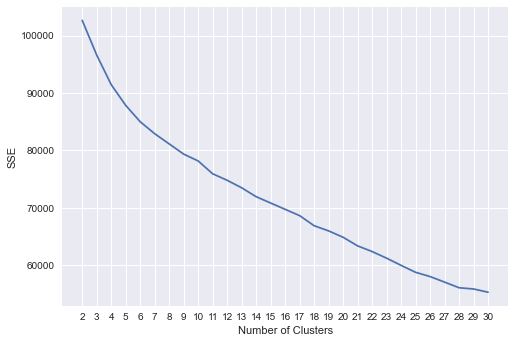

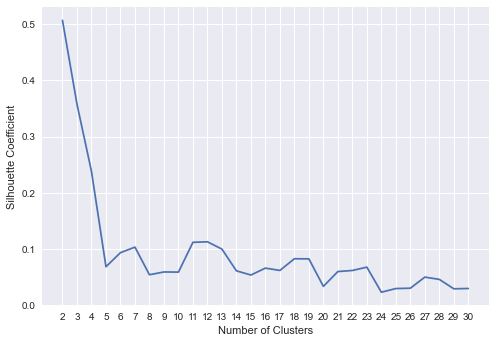

In [48]:
choose_k(scaled_df)

In [49]:
# Reduce dimensionality of scaled DataFrame (df) to explain n% of the variance of the data

def pca_reduce(df, n):
    pca = PCA(n_components=n)
    pcs = pca.fit_transform(scaled_df)
    features = range(pca.n_components_)
    cum_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.bar(features, cum_variance, color='blue')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.xticks(np.arange(0, len(cum_variance), 5))
    plt.show()
    return pd.DataFrame(pcs)

In [50]:
# Perform k-means with dataset df and K clusters

def perform_kmeans(orig, df, k, supp = False):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500, random_state=3425)
    members = kmeans.fit_predict(df)
    subset = orig[['Symbol','Name','Sector']]
    subset['Cluster'] = members
    display_members(subset)
    print()
    print()
    print(pd.crosstab(subset['Sector'], subset['Cluster']))
    sns.heatmap(pd.crosstab(subset['Sector'], subset['Cluster'], normalize='columns'), cmap="YlGnBu")
    if not supp:
        large = large_cluster(subset)
        return large

In [51]:
def display_members(subset):
    counts = subset.groupby('Cluster').count()['Name']
    clusters = list(counts[counts < 10].index)
    filtered = subset[subset['Cluster'].isin(clusters)].sort_values(by='Cluster')
    print(filtered[['Name','Sector','Cluster']])

In [52]:
def large_cluster(subset):
    counts = subset.groupby('Cluster').count()['Name']
    large = list(counts[counts > 150].index)[0]
    large_cluster = subset[subset['Cluster'] == large]
    large_symb = large_cluster['Symbol']
    modified = main[main['Symbol'].isin(large_symb)]
    return modified

                               Name                      Sector  Cluster
26             Alphabet Inc Class A      Information Technology        2
28                   Amazon.com Inc      Consumer Discretionary        2
448                     Wells Fargo                  Financials        3
245            JPMorgan Chase & Co.                  Financials        3
60             Bank of America Corp                  Financials        3
104                  Citigroup Inc.                  Financials        3
111               Colgate-Palmolive            Consumer Staples        7
290                 Microsoft Corp.      Information Technology        8
170               Exxon Mobil Corp.                      Energy        8
112                   Comcast Corp.      Consumer Discretionary        8
53                         AT&T Inc  Telecommunication Services        8
47                       Apple Inc.      Information Technology        8
437          Verizon Communications  Telecommunicat

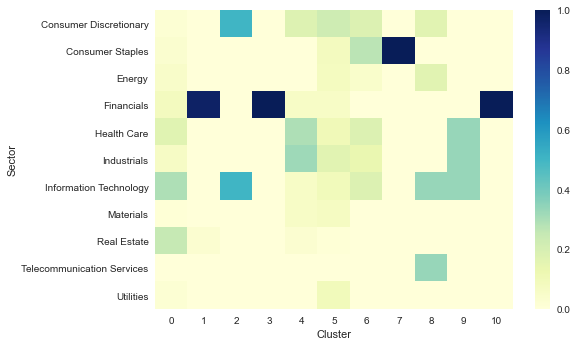

In [53]:
res = perform_kmeans(main, scaled_df, 11)

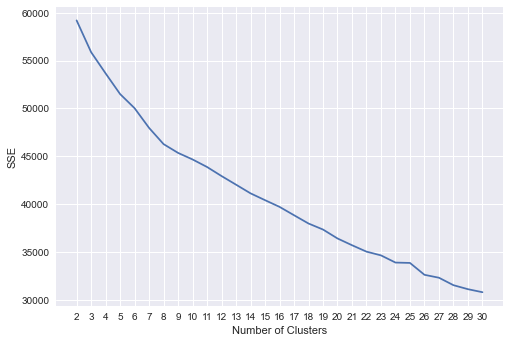

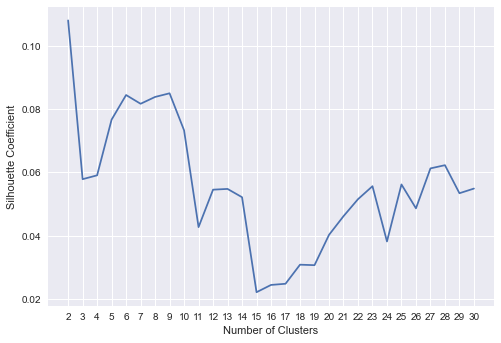

In [54]:
lg_clus = prep_data(res)
choose_k(lg_clus)

                                   Name                  Sector  Cluster
121                           Coty, Inc        Consumer Staples        4
211                    Hess Corporation                  Energy        4
272                  Marathon Oil Corp.                  Energy        4
313                    Noble Energy Inc                  Energy        4
192                         Gartner Inc  Information Technology        6
33   American International Group, Inc.              Financials        8


Cluster                     0   1   2   3   4   5   6   7   8   9   10
Sector                                                                
Consumer Discretionary       1   3   6   1   0  29   0  11   0   9   0
Consumer Staples             2   0   4   0   1   4   0   4   0   7   0
Energy                       1   2   3   7   3   3   0   1   0   0   1
Financials                   0   1   0   0   0   5   0   3   1   6   0
Health Care                  1   1   2   0   0   6   0   6   

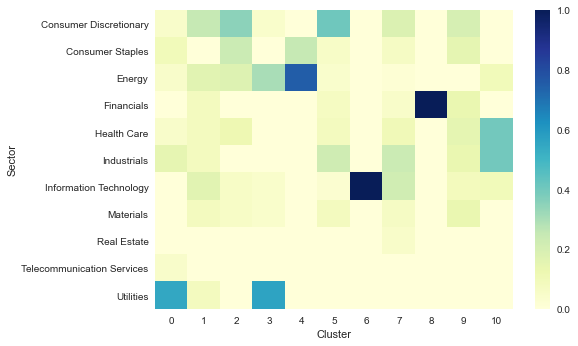

In [55]:
perform_kmeans(res, lg_clus,11,True)

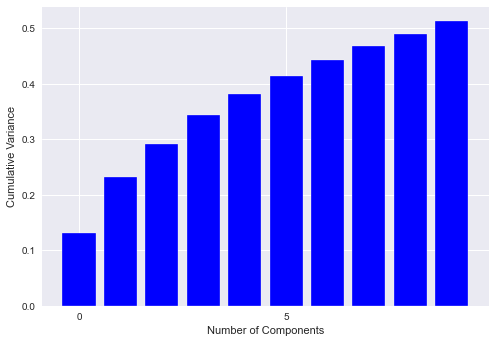

In [56]:
PCA_df_50 = pca_reduce(scaled_df, .5)

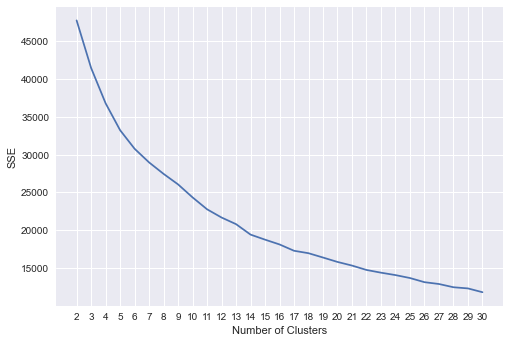

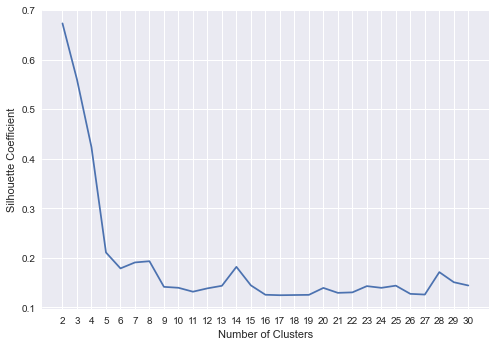

In [57]:
choose_k(PCA_df_50)

                     Name                  Sector  Cluster
60   Bank of America Corp              Financials        2
104        Citigroup Inc.              Financials        2
245  JPMorgan Chase & Co.              Financials        2
448           Wells Fargo              Financials        2
200   Goldman Sachs Group              Financials        3
297        Morgan Stanley              Financials        3
26   Alphabet Inc Class A  Information Technology        4
28         Amazon.com Inc  Consumer Discretionary        4
56           AutoZone Inc  Consumer Discretionary        4


Cluster                     0   1  2  3  4   5   6   7
Sector                                                
Consumer Discretionary      1  54  0  0  2   1   9   7
Consumer Staples            1  18  0  0  0   1   1  11
Energy                      2  19  0  0  0   3   1   3
Financials                  0  22  4  2  0  23  11   2
Health Care                 2  21  0  0  0  14  14   7
Industrials            

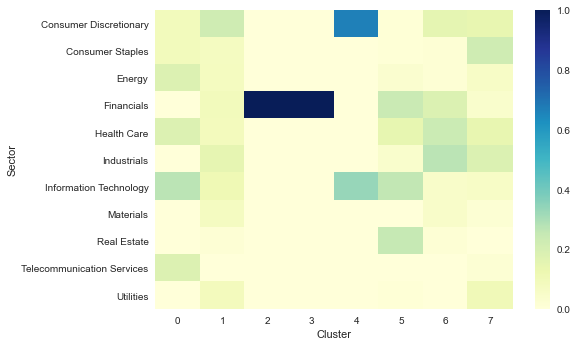

In [58]:
res = perform_kmeans(main, PCA_df_50, 8)

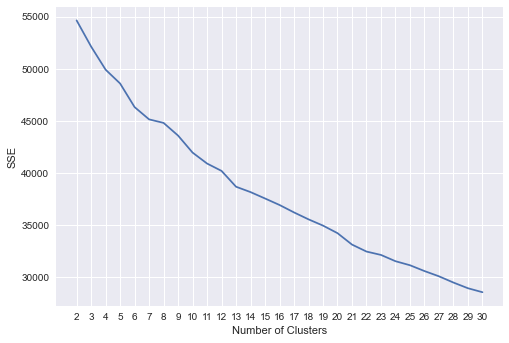

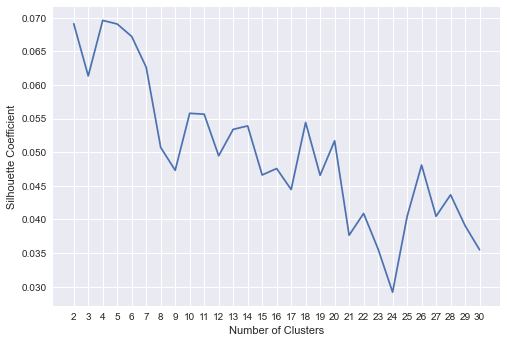

In [59]:
lg_clus = prep_data(res)
choose_k(lg_clus)

                                   Name                  Sector  Cluster
72            Brighthouse Financial Inc              Financials        3
181               Flowserve Corporation             Industrials        4
33   American International Group, Inc.              Financials        5
9            Advanced Micro Devices Inc  Information Technology        8
214                             Hologic             Health Care        8
121                           Coty, Inc        Consumer Staples        9
211                    Hess Corporation                  Energy        9
272                  Marathon Oil Corp.                  Energy        9
313                    Noble Energy Inc                  Energy        9
358                       QUALCOMM Inc.  Information Technology       10


Cluster                 0   1   2   3   4   5   6   7   8   9   10
Sector                                                            
Consumer Discretionary  19  22   7   0   0   0   4   2   0   

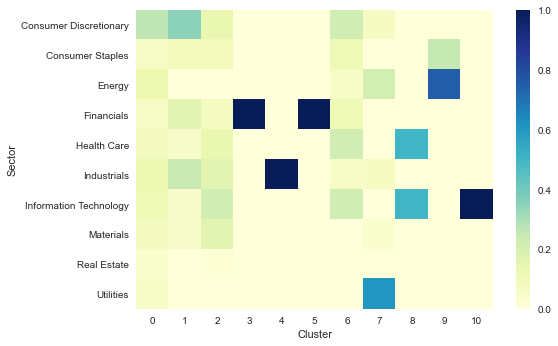

In [60]:
perform_kmeans(res, lg_clus,11,True)

                               Name                      Sector  Cluster
181           Flowserve Corporation                 Industrials        0
252                   Kinder Morgan                      Energy        0
192                     Gartner Inc      Information Technology        0
245            JPMorgan Chase & Co.                  Financials        4
104                  Citigroup Inc.                  Financials        4
60             Bank of America Corp                  Financials        4
448                     Wells Fargo                  Financials        4
28                   Amazon.com Inc      Consumer Discretionary        6
26             Alphabet Inc Class A      Information Technology        6
56                     AutoZone Inc      Consumer Discretionary        6
95                    Chevron Corp.                      Energy        7
53                         AT&T Inc  Telecommunication Services        7
112                   Comcast Corp.      Consumer D

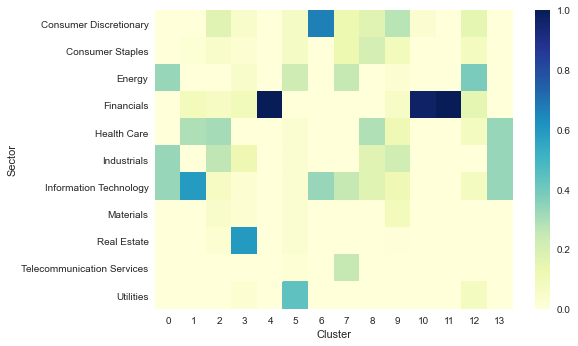

In [61]:
res = perform_kmeans(main, PCA_df_50, 14)

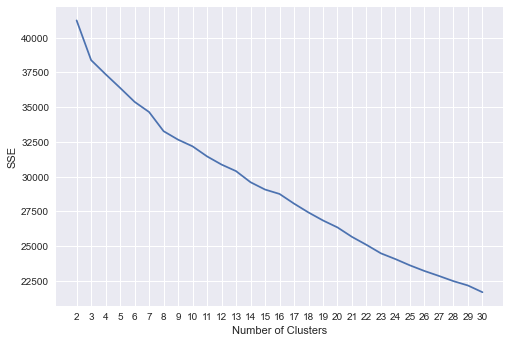

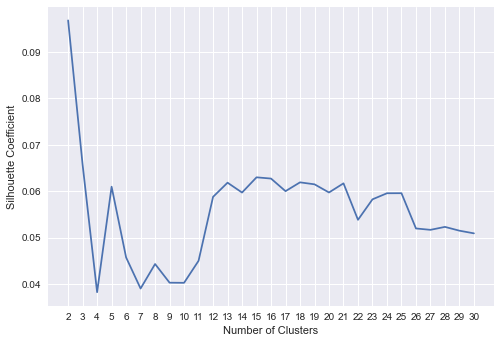

In [62]:
lg_clus = prep_data(res)
choose_k(lg_clus)

                            Name                  Sector  Cluster
358                QUALCOMM Inc.  Information Technology        3
267                  Lowe's Cos.  Consumer Discretionary        4
424  United Continental Holdings             Industrials        4
400                 Target Corp.  Consumer Discretionary        4
131         Delta Air Lines Inc.             Industrials        4
256                   Kroger Co.        Consumer Staples        4
37        AmerisourceBergen Corp             Health Care        6
80          Cardinal Health Inc.             Health Care        6
341                  Phillips 66                  Energy        7
273           Marathon Petroleum                  Energy        7
268               LyondellBasell               Materials        7
444     Walgreens Boots Alliance        Consumer Staples        7
432                Valero Energy                  Energy        7
136   Discovery Communications-A  Consumer Discretionary        8
422       

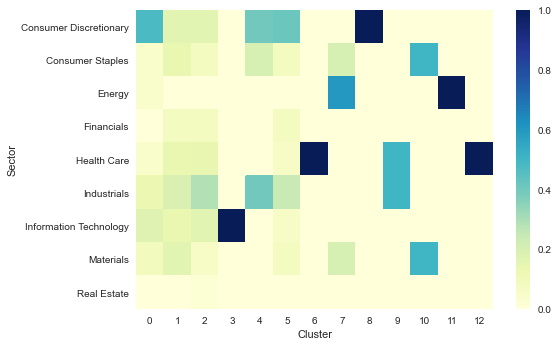

In [63]:
perform_kmeans(res, lg_clus,13,True)

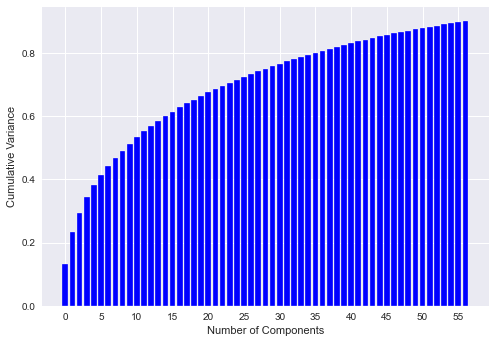

In [64]:
PCA_df_90 = pca_reduce(scaled_df, .9)

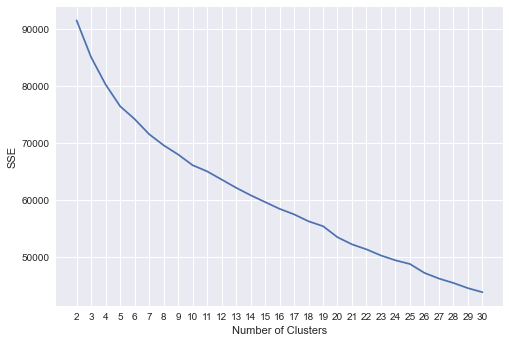

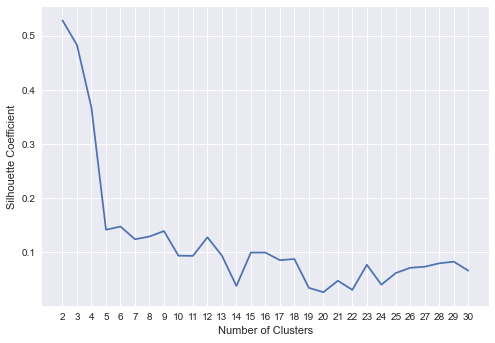

In [65]:
choose_k(PCA_df_90)

                               Name                      Sector  Cluster
448                     Wells Fargo                  Financials        2
60             Bank of America Corp                  Financials        2
104                  Citigroup Inc.                  Financials        2
437          Verizon Communications  Telecommunication Services        3
338                     Pfizer Inc.                 Health Care        3
290                 Microsoft Corp.      Information Technology        3
443                 Wal-Mart Stores            Consumer Staples        3
112                   Comcast Corp.      Consumer Discretionary        3
170               Exxon Mobil Corp.                      Energy        3
53                         AT&T Inc  Telecommunication Services        3
47                       Apple Inc.      Information Technology        3
95                    Chevron Corp.                      Energy        3
214                         Hologic                

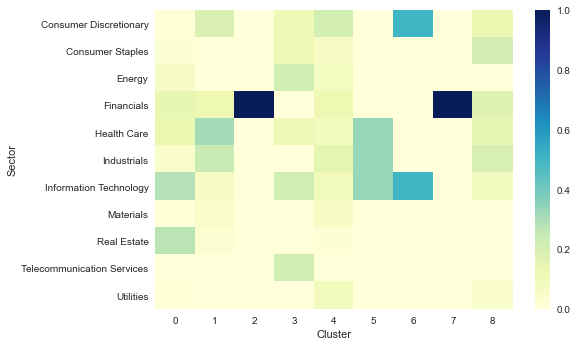

In [66]:
res = perform_kmeans(main, PCA_df_90, 9)

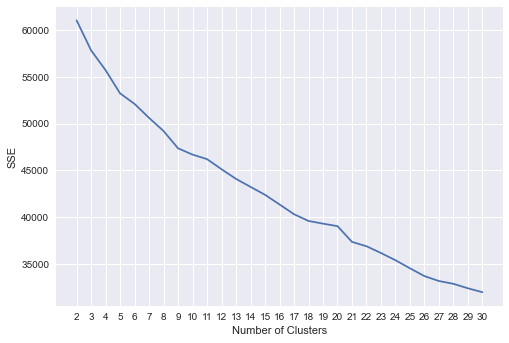

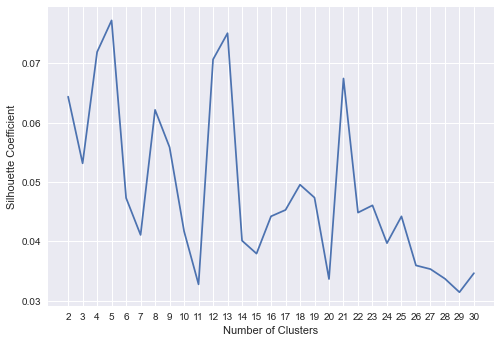

In [67]:
lg_clus = prep_data(res)
choose_k(lg_clus)

                                   Name                  Sector  Cluster
62                     BB&T Corporation              Financials        3
394                      SunTrust Banks              Financials        3
111                   Colgate-Palmolive        Consumer Staples        4
358                       QUALCOMM Inc.  Information Technology        5
33   American International Group, Inc.              Financials        6
206          Hartford Financial Svc.Gp.              Financials        6
105            Citizens Financial Group              Financials        7
177                 Fifth Third Bancorp              Financials        7
221               Huntington Bancshares              Financials        7
249                             KeyCorp              Financials        7
334           People's United Financial              Financials        7
367             Regions Financial Corp.              Financials        7
463                       Zions Bancorp            

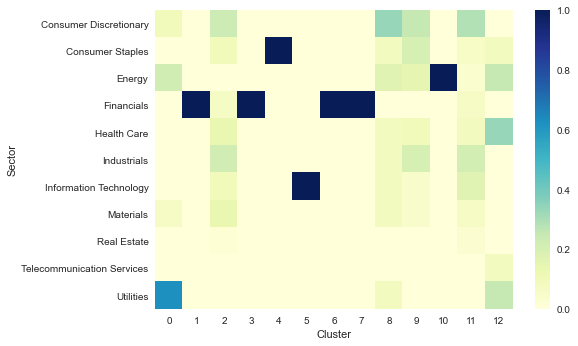

In [68]:
perform_kmeans(res, lg_clus,13,True)

                               Name                      Sector  Cluster
448                     Wells Fargo                  Financials        2
60             Bank of America Corp                  Financials        2
104                  Citigroup Inc.                  Financials        2
245            JPMorgan Chase & Co.                  Financials        2
53                         AT&T Inc  Telecommunication Services        3
437          Verizon Communications  Telecommunication Services        3
26             Alphabet Inc Class A      Information Technology        4
28                   Amazon.com Inc      Consumer Discretionary        4
297                  Morgan Stanley                  Financials        5
200             Goldman Sachs Group                  Financials        5
244  Johnson Controls International                 Industrials        7
9        Advanced Micro Devices Inc      Information Technology        7
214                         Hologic                

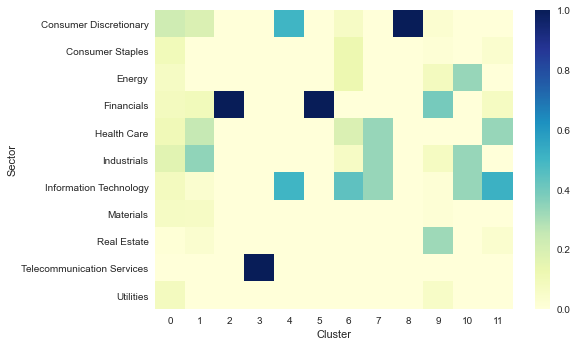

In [69]:
res = perform_kmeans(main, PCA_df_90, 12)

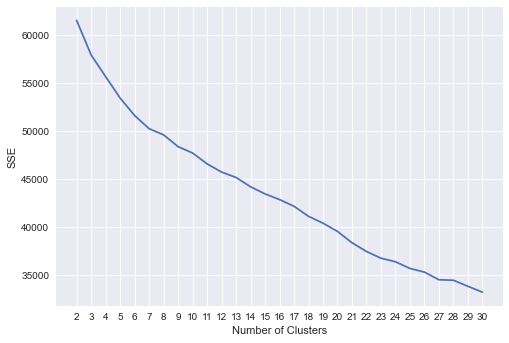

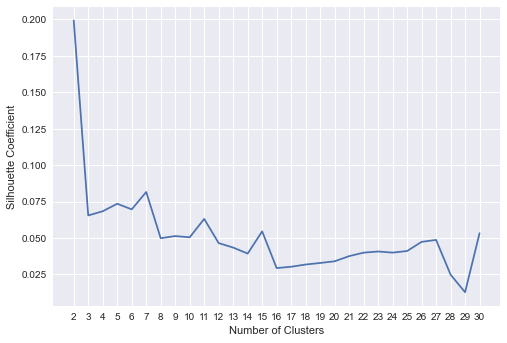

In [70]:
lg_clus = prep_data(res)
choose_k(lg_clus)

                                   Name                  Sector  Cluster
428                 United Technologies             Industrials        0
215                          Home Depot  Consumer Discretionary        0
426               United Parcel Service             Industrials        0
335                        PepsiCo Inc.        Consumer Staples        0
340         Philip Morris International        Consumer Staples        0
125                          CVS Health        Consumer Staples        0
411             The Walt Disney Company  Consumer Discretionary        0
388                        Southern Co.               Utilities        2
117                 Consolidated Edison               Utilities        2
144                         Duke Energy               Utilities        2
152                        Edison Int'l               Utilities        2
156                       Entergy Corp.               Utilities        2
166                        Exelon Corp.            

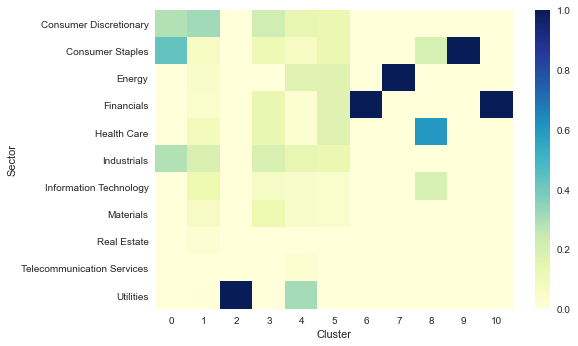

In [71]:
perform_kmeans(res, lg_clus,11,True)

In [72]:
def choose_eps(df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [73]:
def run_db(df,eps):
    dbclus = DBSCAN(eps=17).fit(df)
    return dbclus.labels_

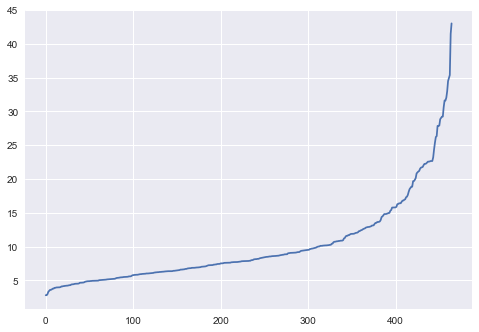

In [74]:
choose_eps(scaled_df)

In [75]:
run_db(scaled_df,17)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0, -1, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

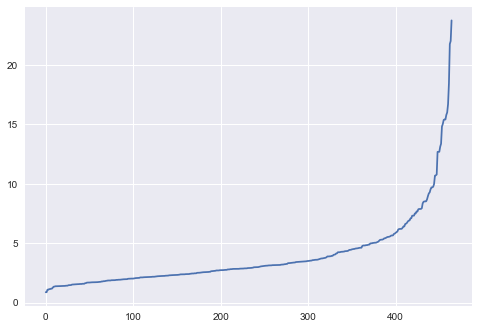

In [76]:
choose_eps(PCA_df_50)

In [77]:
run_db(PCA_df_50,7)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

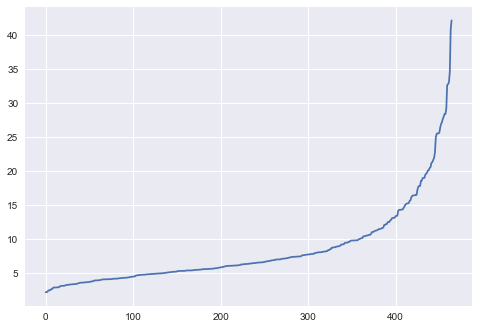

In [78]:
choose_eps(PCA_df_90)

In [79]:
run_db(PCA_df_90,17)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0, -1, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

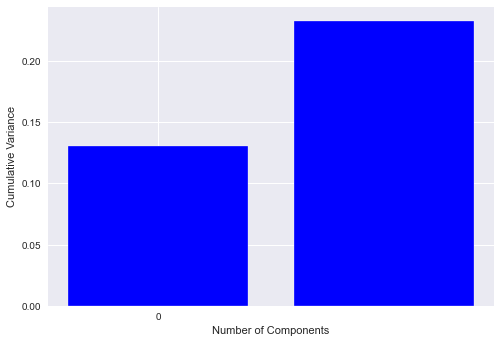

In [80]:
PCA_small = pca_reduce(scaled_df, 2)

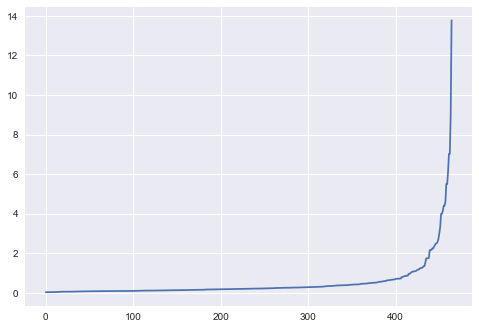

In [81]:
choose_eps(PCA_small)

In [86]:
run_db(PCA_small,.1)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0